In [1]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
atl_bg = gpd.read_file('atl_bg.geojson')
#atl_bg = gpd.read_file("atl_bg.geojson")
atl_bg = atl_bg.to_crs(epsg=32616)

In [3]:
place_name = "Atlanta, Georgia"
tags_commercial = {
    'shop': [
        'supermarket', 'convenience', 'grocery', 'food', 'organic', # Grocery
        'books', 'bookstore', 'newsagent', # Books
    ],
    'amenity': [
        'restaurant', 'cafe', 'food_court', 'bistro', 'fast_food', # Restaurants
        'bank', 'atm', # Banks
        'school', 'college', 'university', 'kindergarten', 'music_school', 'language_school', 'driving_school', # Schools
        'cinema', 'theatre', 'nightclub', 'casino', 'arts_centre' # Entertainment
    ],
    'leisure': [
        'park', 'garden', 'nature_reserve', # Parks
        'sports_centre', 'stadium', 'amusement_arcade', 'dance', 'bowling_alley', # Entertainment
    ],
    'landuse': [
        'recreation_ground', 'grass', 'greenfield' # Parks
    ],
    'tourism': [
        'attraction', 'theme_park', 'zoo' # Entertainment
    ]
}

C:\Users\joshu\AppData\Local\Temp\ipykernel_34200\2379983919.py:1: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  atl_commercial = ox.geometries_from_place(place_name, tags_commercial)


                       barrier                        geometry amenity  \
element_type osmid                                                       
node         358679583     NaN  POINT (743451.678 3738098.571)  school   
             358679718     NaN  POINT (740487.925 3744444.619)     NaN   
             358682163     NaN  POINT (740296.450 3733649.574)  school   
             358682296     NaN  POINT (739202.972 3738215.626)  school   
             358682299     NaN  POINT (744634.220 3748342.369)  school   

                                                            name check_date  \
element_type osmid                                                            
node         358679583         Archbishop R Ryan Memorial School        NaN   
             358679718                     Atlanta Memorial Park        NaN   
             358682163            Capitol View Elementary School        NaN   
             358682296  KIPP West Atlanta Young Scholars Academy        NaN   
       

<Axes: >

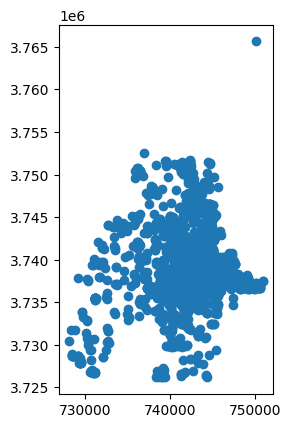

In [4]:
atl_commercial = ox.geometries_from_place(place_name, tags_commercial)
atl_commercial = atl_commercial.to_crs(epsg=32616)

atl_commercial['geometry'] = atl_commercial['geometry'].apply(lambda x: x.centroid if x.geom_type == 'Polygon' or x.geom_type == 'MultiPolygon' else x)
atl_commercial['geometry'] = atl_commercial['geometry'].apply(lambda x: x if x.geom_type == 'Point' else x[0] if x.geom_type == 'MultiPoint' else x)

print(atl_commercial.head())

atl_commercial.plot()


tags_commercial = {
    'shop': [
        'supermarket', 'convenience', 'grocery', 'food', 'organic', # Grocery
        'books', 'bookstore', 'newsagent', # Books
    ],
    'amenity': [
        'restaurant', 'cafe', 'food_court', 'bistro', 'fast_food', # Restaurants
        'bank', 'atm', # Banks
        'school', 'college', 'university', 'kindergarten', 'music_school', 'language_school', 'driving_school', # Schools
        'cinema', 'theatre', 'nightclub', 'casino', 'arts_centre' # Entertainment
    ],
    'leisure': [
        'park', 'garden', 'nature_reserve', # Parks
        'sports_centre', 'stadium', 'amusement_arcade', 'dance', 'bowling_alley', # Entertainment
    ],
    'landuse': [
        'recreation_ground', 'grass', 'greenfield' # Parks
    ],
    'tourism': [
        'attraction', 'theme_park', 'zoo' # Entertainment
    ]
}

atl_commercial = ox.features_from_place(place_name, tags_commercial)
atl_commercial = atl_commercial.to_crs(epsg=32616)

commercial_polygons = atl_commercial[atl_commercial.geom_type == 'Polygon']
commercial_points = atl_commercial[atl_commercial.geom_type == 'Point']

commercial_polygons['area'] = commercial_polygons.area
average_area = commercial_polygons['area'].mean()

commercial_points['area'] = average_area
combined_commercial = pd.concat([commercial_polygons, commercial_points])

atl_commercial = combined_commercial

atl_commercial['commercial_area'] = atl_commercial.area

print(atl_commercial[['geometry', 'area']])
atl_commercial.plot(column='area', legend=True)


In [5]:
atl_bg_sifted = atl_bg[['GEOID','geometry','ALAND']]

gdf = gpd.sjoin(atl_bg_sifted, atl_commercial, how='left', predicate='contains')



# Aggregate the data to count commercial points per blockgroup
commercial_count = gdf.groupby('GEOID').size()  # Assuming 'GEOID' from atl_bg is suffixed with '_bg' due to lsuffix

print(commercial_count)

# Map the counts back to atl_bg without duplicating rows
atl_bg['commercial_count'] = atl_bg['GEOID'].map(commercial_count)


# Fill missing values with zero
atl_bg['commercial_count'] = atl_bg['commercial_count'].fillna(0).astype(int)

# Optionally, calculate the density
atl_bg['commercial_density'] = atl_bg['commercial_count'] / atl_bg['ALAND']

print(atl_bg.columns)






GEOID
130630403021     1
130630403081     1
130630403091     1
130630403093     1
130639800001     3
                ..
131210119022     6
131210120001    10
131210120002     3
131210120003     2
131219800001    14
Length: 500, dtype: int64
Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'GEOID', 'GEOIDFQ',
       'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT',
       'INTPTLON', 'index_right', 'NAME', 'CLASS', 'ST', 'STFIPS', 'PLACEFIPS',
       'POP2010', 'STPLFIPS', 'geometry', 'commercial_count',
       'commercial_density'],
      dtype='object')


In [6]:
gdf = atl_bg
print(gdf.loc[np.isnan(gdf['commercial_density']), 'commercial_density'])

gdf.loc[np.isnan(gdf['commercial_density']), 'commercial_density'] = 0
max(np.isnan(gdf['commercial_density']))

max_value = gdf["commercial_density"].max()
print(max_value)

Series([], Name: commercial_density, dtype: float64)
0.0002178570131803493


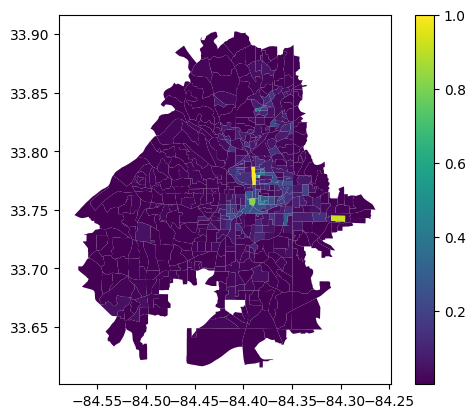

    STATEFP COUNTYFP TRACTCE BLKGRPCE         GEOID                GEOIDFQ  \
0        13      121  009301        2  131210093012  1500000US131210093012   
1        13      121  009105        1  131210091051  1500000US131210091051   
2        13      121  009408        1  131210094081  1500000US131210094081   
3        13      121  000602        1  131210006021  1500000US131210006021   
4        13      121  007809        2  131210078092  1500000US131210078092   
..      ...      ...     ...      ...           ...                    ...   
495      13      089  021405        4  130890214054  1500000US130890214054   
496      13      089  020500        3  130890205003  1500000US130890205003   
497      13      089  020901        2  130890209012  1500000US130890209012   
498      13      089  020902        1  130890209021  1500000US130890209021   
499      13      089  023701        1  130890237011  1500000US130890237011   

          NAMELSAD  MTFCC FUNCSTAT    ALAND  ...  CLASS  ST STF

In [7]:

gdf['CDI'] = gdf['commercial_density'] / max_value
gdf = gdf.to_crs(4326)


fig, ax = plt.subplots()
gdf.plot(column='CDI', cmap='viridis', legend=True, ax=ax)
plt.show()



print(gdf)



gdf.to_file("atl_CDI.geojson")

